In [1]:
import os
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from ipfml.processing import transform, segmentation, compression
from ipfml import utils

from numpy.linalg import svd

In [3]:
# kitchen scene
scene_name = "p3d_kitchen"
scene_to_study = "/home/jbuisine/Documents/Thesis/Development/thesis-data/SIN3D_HD_all_center/p3d_kitchen-view0_part6"
thresholds_scene = [1980,2760,1900,1935,1825,1850,2290,1330,1265,2310,2380,1975,1405,2335,2005,2700]
mean_thresholds = int(np.mean(thresholds_scene) / 20) * 20 + 20
images_indices = np.arange(20, 10020, 20)

In [ ]:
# living-room
scene_name = "p3d_living-room"
scene_to_study = "/home/jbuisine/Documents/Thesis/Development/thesis-data/SIN3D_HD_all_center/p3d_living-room-view0_part6"
thresholds_scene = [5197,4682,4825,4254,4197,4511,4711,3597,4911,4625,5025,4797,4482,4825,4425,4340]
mean_thresholds = int(np.mean(thresholds_scene) / 20) * 20 + 20
images_indices = np.arange(20, 10020, 20)

In [2]:
# living-room-3
scene_name = "p3d_living-room-3"
scene_to_study = "/home/jbuisine/Documents/Thesis/Development/thesis-data/SIN3D_HD_all_center/p3d_living-room-3-view0_part6"
thresholds_scene = [8680,5286,6553,2293,7153,7086,6420,2626,4420,6580,4560,7820,7086,8286,6286,6693]
mean_thresholds = int(np.mean(thresholds_scene) / 20) * 20 + 20
images_indices = np.arange(20, 10020, 20)

In [2]:
# indirect
scene_name = "p3d_indirect"
scene_to_study = "/home/jbuisine/Documents/Thesis/Development/thesis-data/reconstructed_center/p3d_indirect-view0_part6"
thresholds_scene = [2466,933,1533,2800,920,980,866,2200,653,920,1533,1666,980,1133,866,1060]
mean_thresholds = int(np.mean(thresholds_scene) / 20) * 20 + 20
images_indices = np.arange(20, 10020, 20)

In [3]:
images = sorted(os.listdir(scene_to_study))
images_path = [ os.path.join(scene_to_study, i) for i in images ]

In [4]:
pil_images = [Image.open(i) for i in images_path]

### Display SVD convergence into Kitchen scene

In [5]:
SVs_all = []
SVs_start = []
SVs_end = []
indices_to_display = [100, 500, 1500, 3000, 3500, 5000, 6500, 8000, 10000]
indices_to_display.append(mean_thresholds)
indices_to_display = sorted(indices_to_display)
for index, img in enumerate(pil_images):
    
    if images_indices[index] in indices_to_display:
        
        # then compute SVD and add it into SVDs array
        sv = transform.get_LAB_L_SVD_s(np.array(img))
        
        # only keep first interval of SV
        SVs_all.append(sv)
        SVs_start.append(sv[0:200])
        SVs_end.append(sv[200:800])

#### Display SVs

In [22]:
def display_and_save(name, sv_data, normalized):
    # display all data using matplotlib (configure plt)
    fig, ax = plt.subplots(figsize=(40, 15))
    #p_ylim = 0, 0.001

    ax.set_facecolor('#FFFFFF')
    #fig.patch.set_facecolor('#F9F9F9')

    ax.tick_params(labelsize=26)
    #plt.rc('xtick', labelsize=22)
    #plt.rc('ytick', labelsize=22)

    #plt.title(p_scene + ' scene interval information SVD['+ str(begin_data) +', '+ str(end_data) +'], from scenes indices [' + str(begin_index) + ', '+ str(end_index) + '], ' + p_feature + ' feature, ' + p_mode + ', with step of ' + str(p_step) + ', svd norm ' + str(p_norm), fontsize=24)
    ax.set_ylabel('Component values', fontsize=36)
    ax.set_xlabel('Singular value component indices', fontsize=36)

    for id, data in enumerate(sv_data):

        if normalized:
            data = utils.normalize_arr(data)
        #p_label = p_scene + "_" + images_indices[id]
        p_label = str(indices_to_display[id]) + " samples"

        if int(indices_to_display[id]) == int(mean_thresholds):
            ax.plot(data, label=p_label + " (threshold mean)", lw=8, color='red')
        else:
            ax.plot(data, label=p_label, lw=4)

    plt.legend(loc=1, borderaxespad=0.2, fontsize=32)

    start_ylim, end_ylim = (0, 0.001)
    ax.set_ylim(start_ylim, end_ylim)

    #plot_name = scene_name + '_' + p_feature + '_' + str(p_step) + '_' + p_mode + '_' + str(p_norm) + '.png'
    #plt.title('{0} of SV at different samples of {1} scene'.format(name, scene_name), fontsize=40)
    plt.savefig("tmp_images/{0}_{1}_norm_{2}_start.png".format(scene_name, name, int(normalized)) , transparent=False)
    plt.plot()

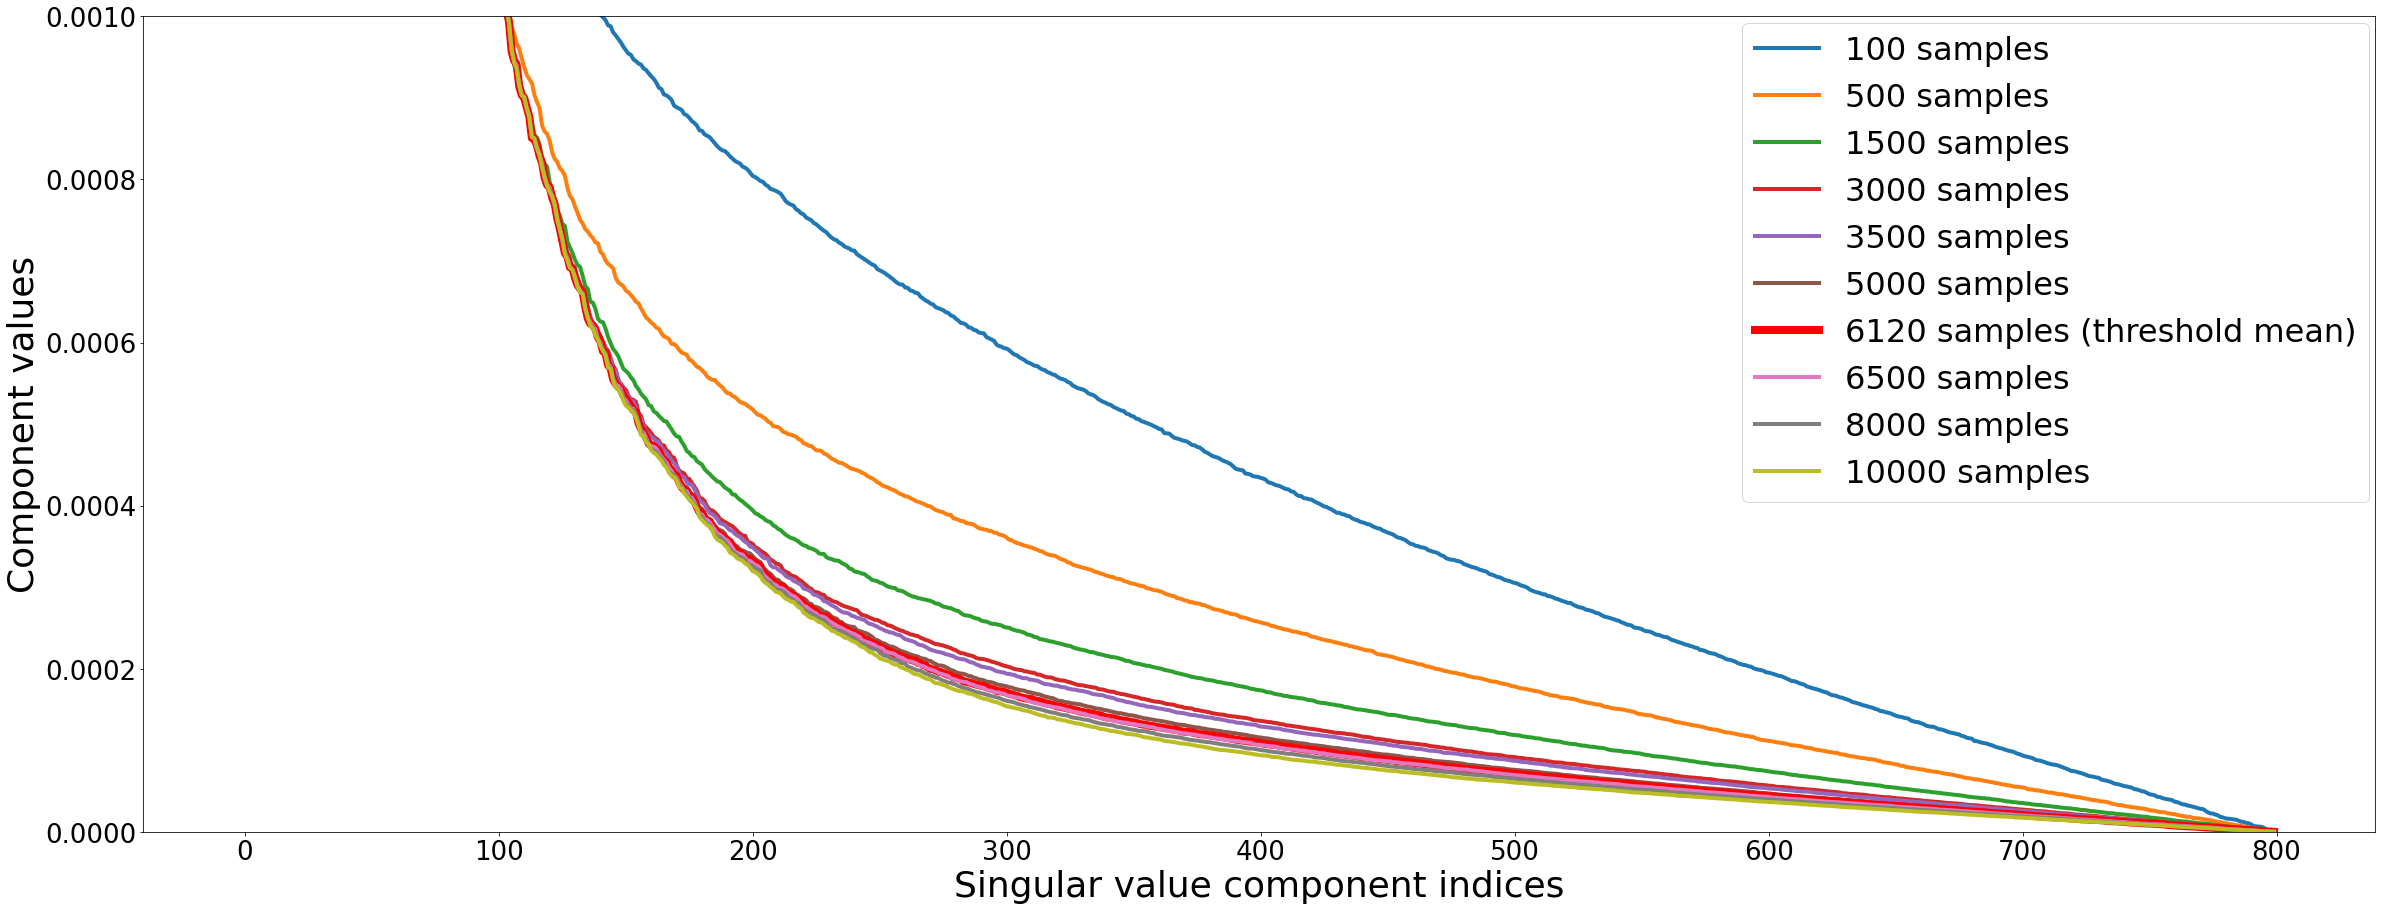

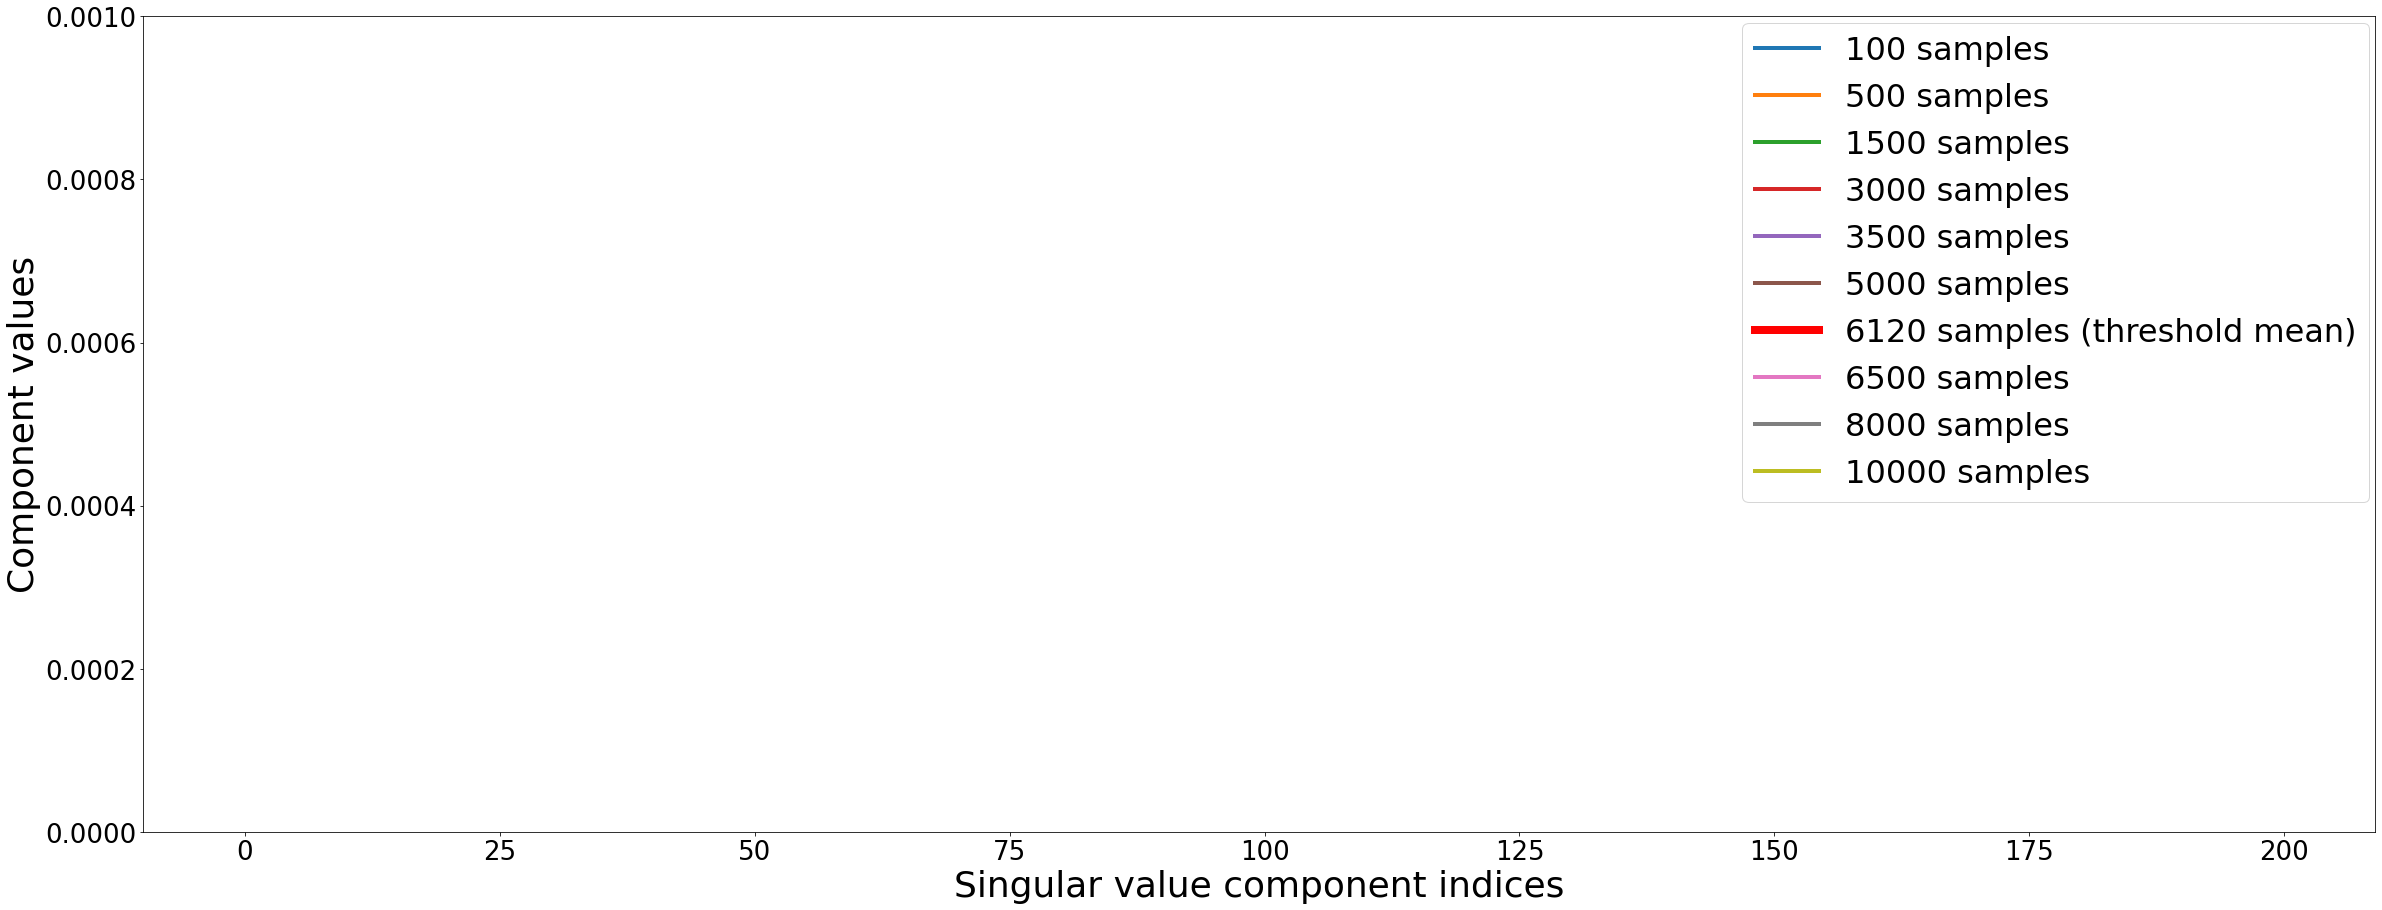

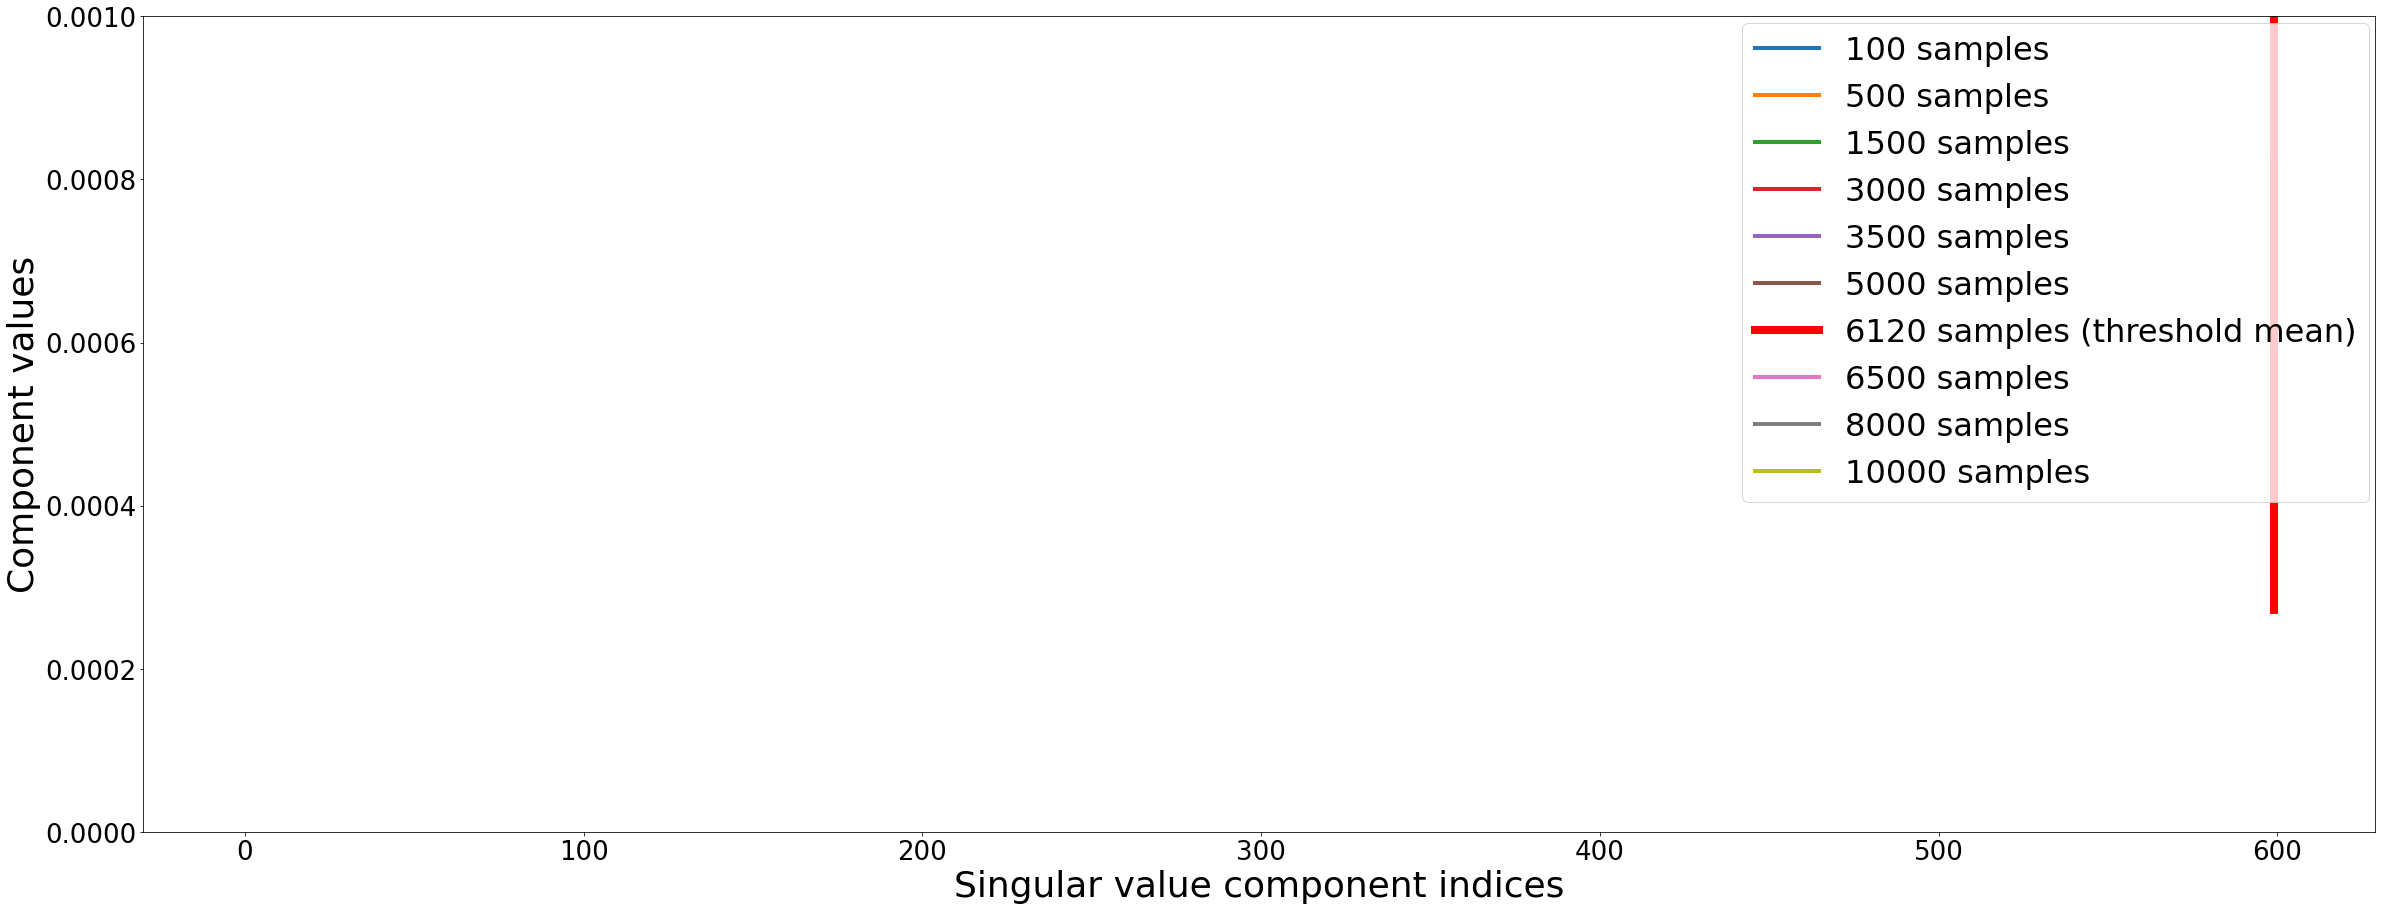

In [23]:
display_and_save("all", SVs_all, True)
display_and_save("start", SVs_start, False)
display_and_save("end", SVs_end, False)

### Zone reconstruction (structure components vs noise components)

In [24]:
def reconstruct_zone(interval, zone):
    
    output_images = []
    begin, end = interval
    lab_img = transform.get_LAB_L(zone)
    lab_img = np.array(lab_img, 'uint8')

    U, s, V = svd(lab_img)

    smat = np.zeros((end-begin, end-begin))
    smat[:, :] = np.diag(s[begin:end])
    output_img = np.dot(U[:, begin:end],  np.dot(smat, V[begin:end, :]))

    output_img = np.array(output_img, 'uint8')
        
    return output_img

In [28]:
most_noisy_image = pil_images[24]
print(images[24])
blocks = segmentation.divide_in_blocks(most_noisy_image, (200, 200))
selected_block = blocks[10]

p3d_living-room-3-view0_00500.png


In [29]:
l_selected_block = transform.get_LAB_L(selected_block)
Image.fromarray(np.array(l_selected_block, 'uint8')).save('tmp_images/original_0_200_' + scene_name +'.png')

In [30]:
structural_zone = reconstruct_zone((0, 50), selected_block)
Image.fromarray(structural_zone).save('tmp_images/reconstructed_0_50_' + scene_name +'.png')

In [31]:
noisy_zone = reconstruct_zone((50, 200), selected_block)
Image.fromarray(noisy_zone).save('tmp_images/noisy_50_200_' + scene_name + '.png')

### SVD entropy other scene

In [32]:
entropies = []
for index, img in enumerate(pil_images):
    
        
    # then compute SVD and add it into SVDs array
    sv = transform.get_LAB_L_SVD_s(np.array(img))
    svd_entropy = utils.get_entropy(sv)
    print("Extraction for {}".format(images_indices[index]))
    entropies.append(svd_entropy)

Extraction for 20
Extraction for 40
Extraction for 60
Extraction for 80
Extraction for 100
Extraction for 120
Extraction for 140
Extraction for 160
Extraction for 180
Extraction for 200
Extraction for 220
Extraction for 240
Extraction for 260
Extraction for 280
Extraction for 300
Extraction for 320
Extraction for 340
Extraction for 360
Extraction for 380
Extraction for 400
Extraction for 420
Extraction for 440
Extraction for 460
Extraction for 480
Extraction for 500
Extraction for 520
Extraction for 540
Extraction for 560
Extraction for 580
Extraction for 600
Extraction for 620
Extraction for 640
Extraction for 660
Extraction for 680
Extraction for 700
Extraction for 720
Extraction for 740
Extraction for 760
Extraction for 780
Extraction for 800
Extraction for 820
Extraction for 840
Extraction for 860
Extraction for 880
Extraction for 900
Extraction for 920
Extraction for 940
Extraction for 960
Extraction for 980
Extraction for 1000
Extraction for 1020
Extraction for 1040
Extraction fo

Extraction for 8280
Extraction for 8300
Extraction for 8320
Extraction for 8340
Extraction for 8360
Extraction for 8380
Extraction for 8400
Extraction for 8420
Extraction for 8440
Extraction for 8460
Extraction for 8480
Extraction for 8500
Extraction for 8520
Extraction for 8540
Extraction for 8560
Extraction for 8580
Extraction for 8600
Extraction for 8620
Extraction for 8640
Extraction for 8660
Extraction for 8680
Extraction for 8700
Extraction for 8720
Extraction for 8740
Extraction for 8760
Extraction for 8780
Extraction for 8800
Extraction for 8820
Extraction for 8840
Extraction for 8860
Extraction for 8880
Extraction for 8900
Extraction for 8920
Extraction for 8940
Extraction for 8960
Extraction for 8980
Extraction for 9000
Extraction for 9020
Extraction for 9040
Extraction for 9060
Extraction for 9080
Extraction for 9100
Extraction for 9120
Extraction for 9140
Extraction for 9160
Extraction for 9180
Extraction for 9200
Extraction for 9220
Extraction for 9240
Extraction for 9260


In [39]:
def display_sv_entropy_and_save(name, h_svd_data):
    # display all data using matplotlib (configure plt)
    fig, ax = plt.subplots(figsize=(25, 20))
    p_ylim = 0, 0.001

    ax.set_facecolor('#FFFFFF')
    #fig.patch.set_facecolor('#F9F9F9')

    ax.tick_params(labelsize=34)
    ax.set_xticks(np.arange(0, 600, step=100))
    #print([ 20 * i + 20 for i in list(range(500)) ])
    ax.set_xticklabels([0, 2000, 4000, 6000, 8000, 10000])
    #plt.rc('xtick', labelsize=22)
    #plt.rc('ytick', labelsize=22)

    #plt.title(p_scene + ' scene interval information SVD['+ str(begin_data) +', '+ str(end_data) +'], from scenes indices [' + str(begin_index) + ', '+ str(end_index) + '], ' + p_feature + ' feature, ' + p_mode + ', with step of ' + str(p_step) + ', svd norm ' + str(p_norm), fontsize=24)
    ax.set_ylabel('SVD-Entropy values', fontsize=40)
    ax.set_xlabel('Number of samples', fontsize=40)

    threshold_id = list(images_indices).index(mean_thresholds)

    ax.plot(h_svd_data, label='SVD-Entropy', lw=6)
    ax.plot([threshold_id, threshold_id], [np.min(entropies), np.max(entropies)], 'k-', lw=10, color='red', label='Human threshold')

    plt.legend(loc=1, borderaxespad=0.2, fontsize=40)

    start_ylim, end_ylim = p_ylim
    #ax.set_ylim(start_ylim, end_ylim)

    #plot_name = scene_name + '_' + p_feature + '_' + str(p_step) + '_' + p_mode + '_' + str(p_norm) + '.png'
    #plt.title('SVD-Entropy at different samples of ' + scene_name + ' scene', fontsize=40)
    plt.savefig("tmp_images/svd_entropy_{0}.png".format(scene_name) , transparent=True)
    plt.plot()

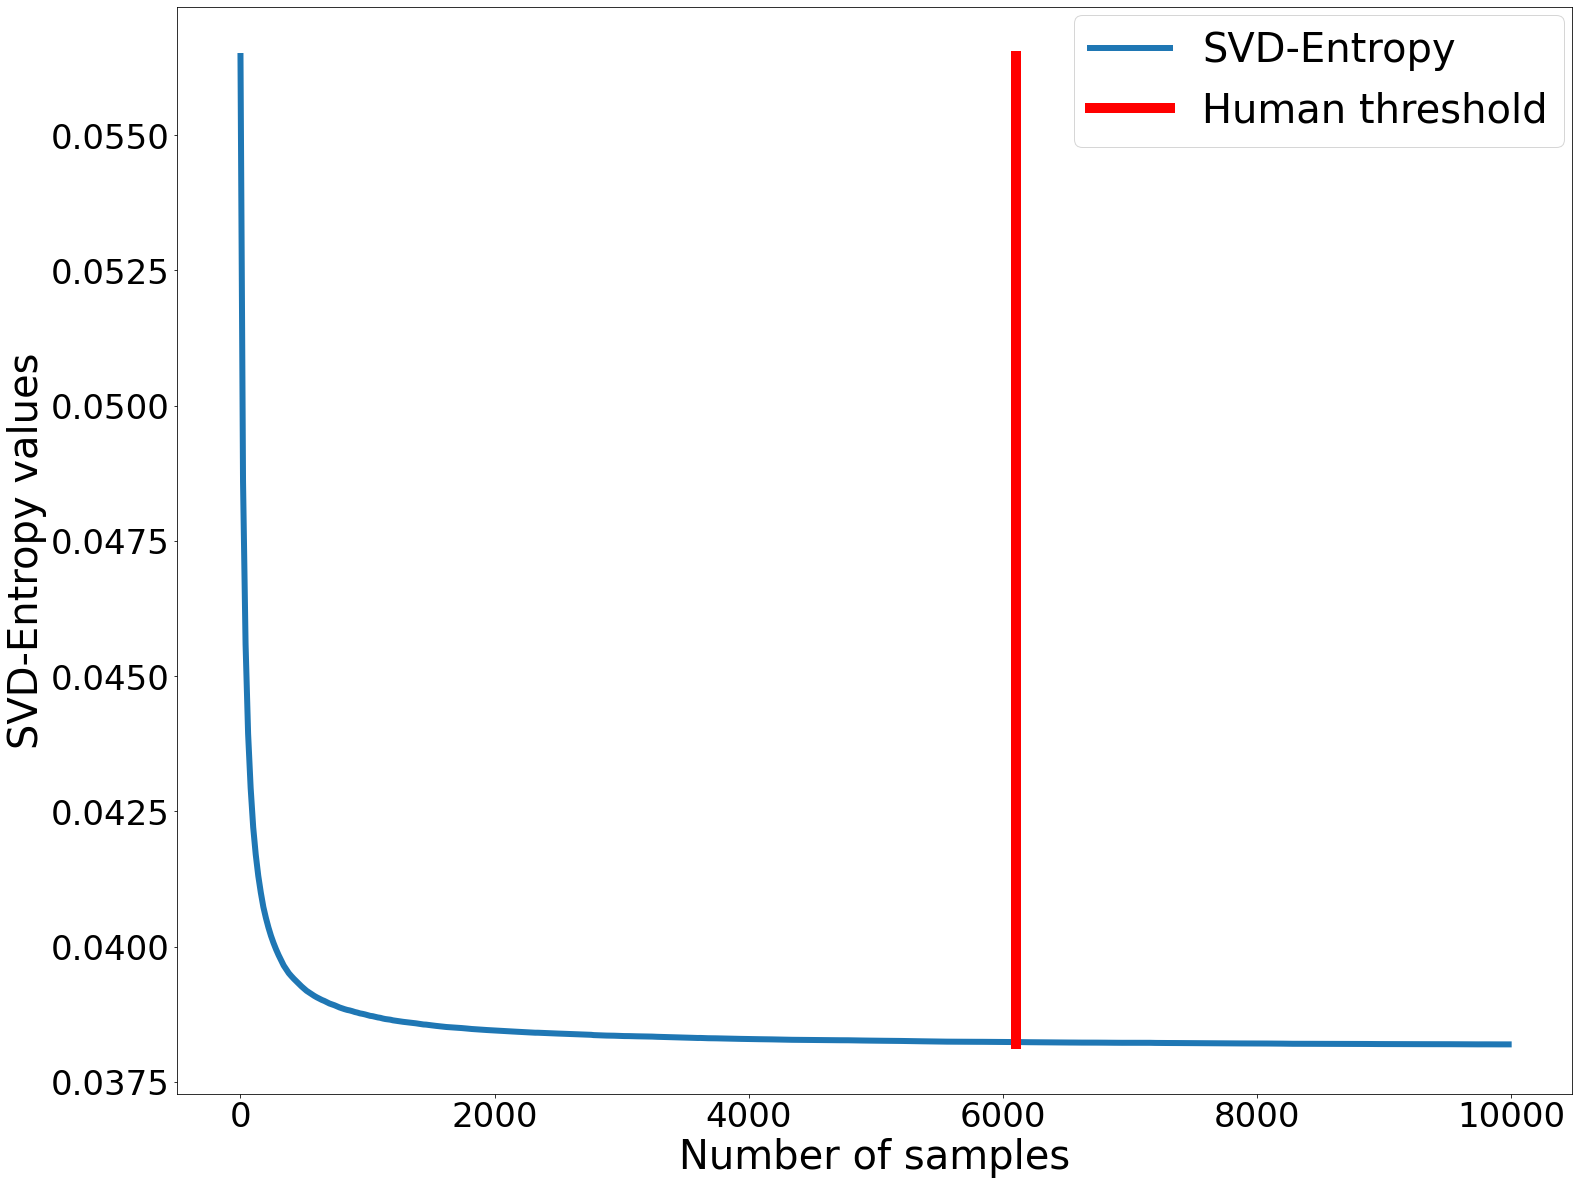

In [92]:
display_sv_entropy_and_save(scene_name, entropies)

### SVD-Entropy for each zone

In [44]:
zones_entropies = {}

n_zones = 16
zones_indices = np.arange(n_zones)
zones_names = [ "block " + str(i + 1) for i in zones_indices ]

for i in zones_indices:
    zones_entropies[i] = []

for index, img in enumerate(pil_images):
    
        
    # then compute SVD and add it into SVDs array
    l_img = transform.get_LAB_L(np.array(img))
    
    blocks = segmentation.divide_in_blocks(l_img, (200, 200))
    
    for b_index, b in enumerate(blocks):
        
        sv = compression.get_SVD_s(b)
        svd_entropy = utils.get_entropy(sv[80:120])
        zones_entropies[b_index].append(svd_entropy)
    print("Extraction for {}".format(images_indices[index]))
    

Extraction for 20
Extraction for 40
Extraction for 60
Extraction for 80
Extraction for 100
Extraction for 120
Extraction for 140
Extraction for 160
Extraction for 180
Extraction for 200
Extraction for 220
Extraction for 240
Extraction for 260
Extraction for 280
Extraction for 300
Extraction for 320
Extraction for 340
Extraction for 360
Extraction for 380
Extraction for 400
Extraction for 420
Extraction for 440
Extraction for 460
Extraction for 480
Extraction for 500
Extraction for 520
Extraction for 540
Extraction for 560
Extraction for 580
Extraction for 600
Extraction for 620
Extraction for 640
Extraction for 660
Extraction for 680
Extraction for 700
Extraction for 720
Extraction for 740
Extraction for 760
Extraction for 780
Extraction for 800
Extraction for 820
Extraction for 840
Extraction for 860
Extraction for 880
Extraction for 900
Extraction for 920
Extraction for 940
Extraction for 960
Extraction for 980
Extraction for 1000
Extraction for 1020
Extraction for 1040
Extraction fo

Extraction for 8280
Extraction for 8300
Extraction for 8320
Extraction for 8340
Extraction for 8360
Extraction for 8380
Extraction for 8400
Extraction for 8420
Extraction for 8440
Extraction for 8460
Extraction for 8480
Extraction for 8500
Extraction for 8520
Extraction for 8540
Extraction for 8560
Extraction for 8580
Extraction for 8600
Extraction for 8620
Extraction for 8640
Extraction for 8660
Extraction for 8680
Extraction for 8700
Extraction for 8720
Extraction for 8740
Extraction for 8760
Extraction for 8780
Extraction for 8800
Extraction for 8820
Extraction for 8840
Extraction for 8860
Extraction for 8880
Extraction for 8900
Extraction for 8920
Extraction for 8940
Extraction for 8960
Extraction for 8980
Extraction for 9000
Extraction for 9020
Extraction for 9040
Extraction for 9060
Extraction for 9080
Extraction for 9100
Extraction for 9120
Extraction for 9140
Extraction for 9160
Extraction for 9180
Extraction for 9200
Extraction for 9220
Extraction for 9240
Extraction for 9260


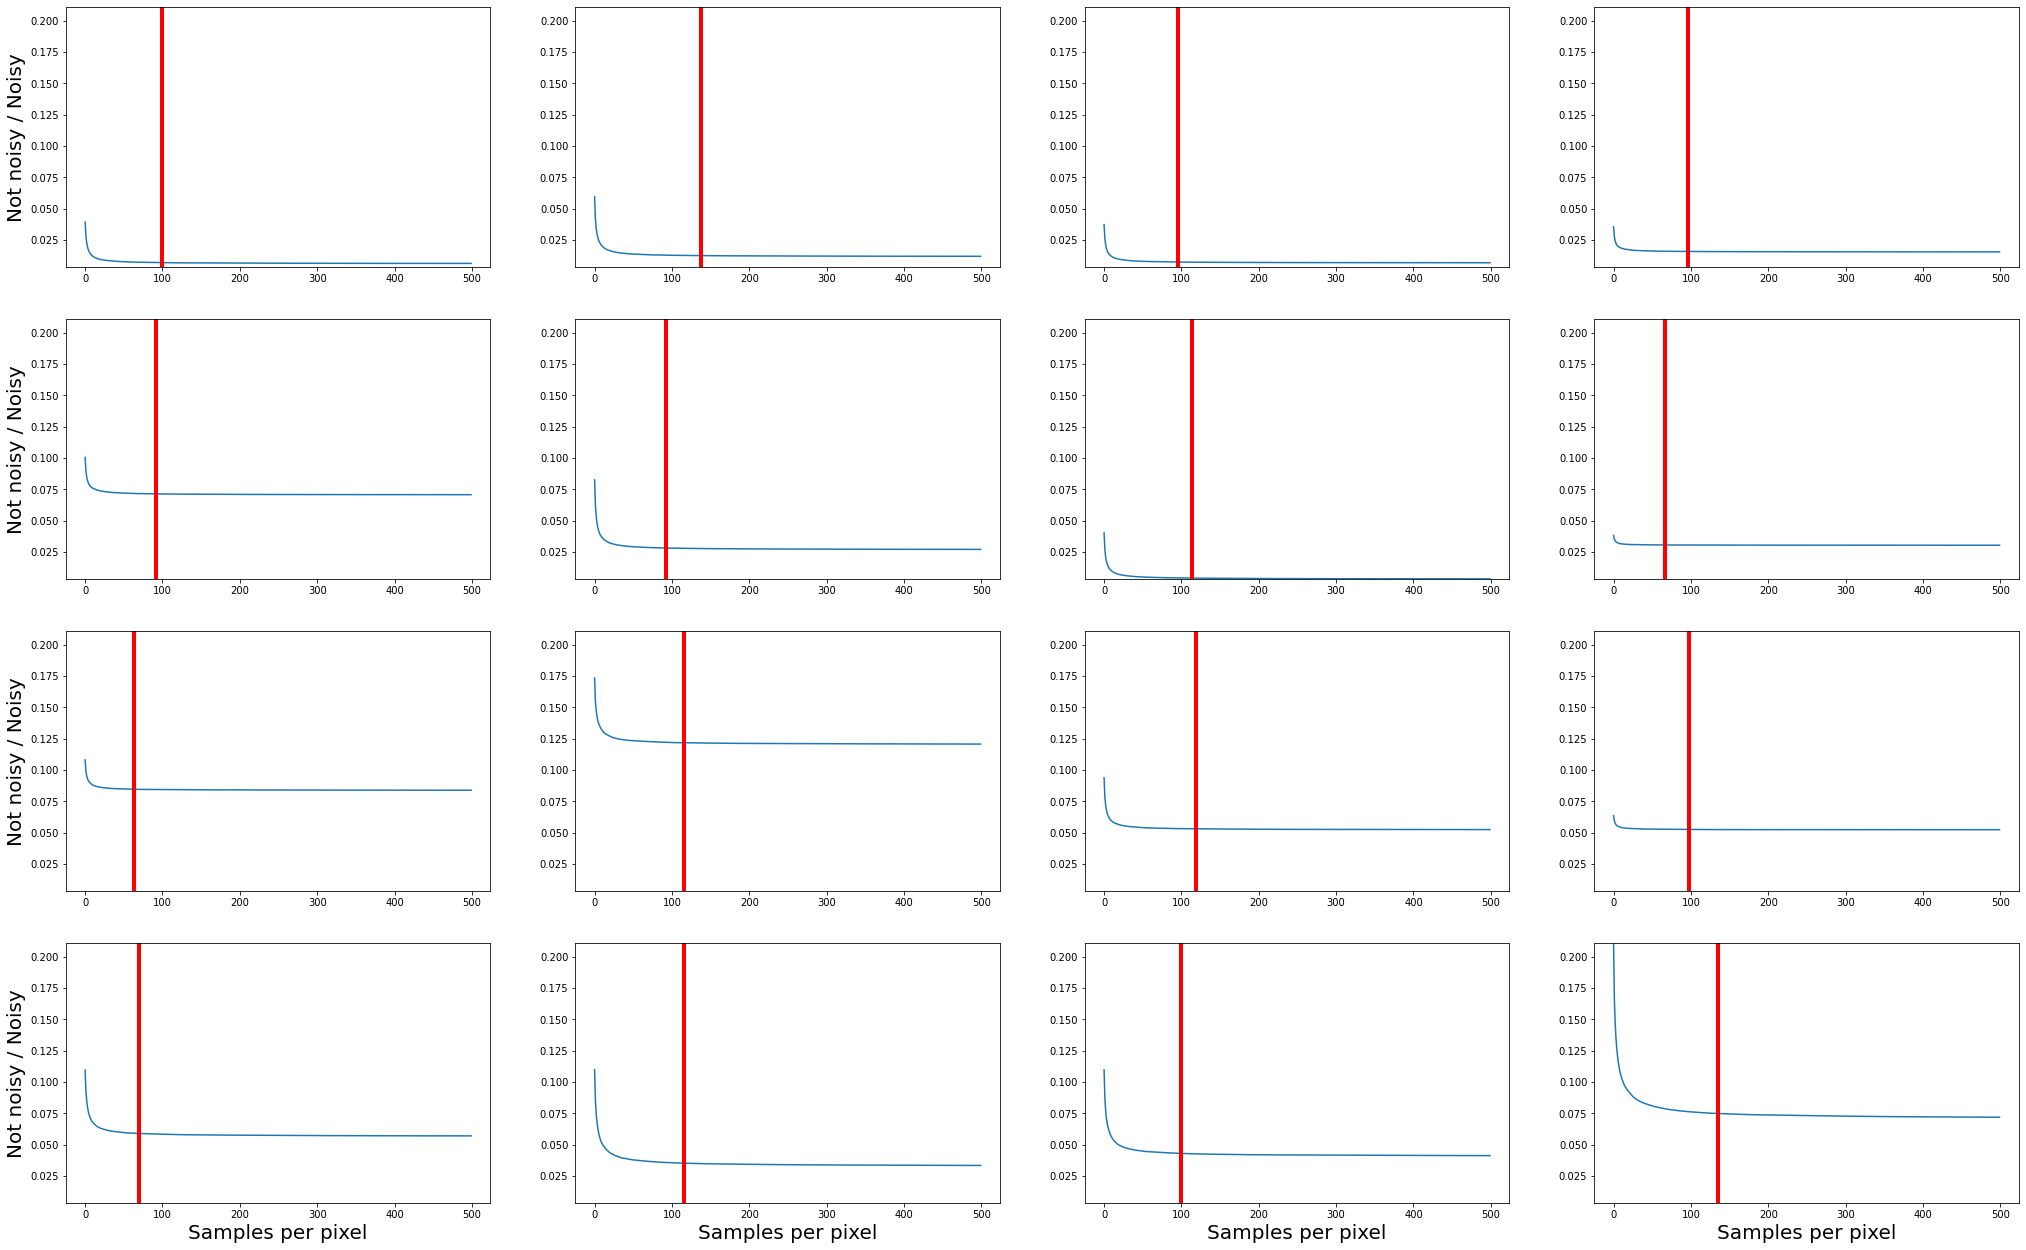

In [15]:
fig=plt.figure(figsize=(35, 22))
#fig.suptitle("Detection simulation for Kitchen scene", fontsize=20)

step_value = 20
label_freq = 50
max_value = 0
min_value = 100000

for index, row in zones_entropies.items():
    if np.max(row) > max_value:
        max_value = np.max(row)
    if np.min(row) < min_value:
        min_value = np.min(row)

for index, row in zones_entropies.items():

    row = np.asarray(row)

    fig.add_subplot(4, 4, (index + 1))
    plt.plot(row)
    
    threshold_value = thresholds_scene[index] - (thresholds_scene[index] % step_value) + step_value
    threshold_id = list(images_indices).index(threshold_value)
    
    # draw vertical line from (70,100) to (70, 250)
    plt.plot([threshold_id, threshold_id], [min_value, max_value], 'k-', lw=4, color='red')

    if index % 4 == 0:
        plt.ylabel('Not noisy / Noisy', fontsize=20)

    if index >= 12:
        plt.xlabel('Samples per pixel', fontsize=20)

    #x_labels = [id * step_value + start_index for id, val in enumerate(row[5:]) if id % label_freq == 0]

    #x = [v for v in np.arange(0, len(row[5:])+1) if v % label_freq == 0]

    #plt.xticks(x, x_labels, rotation=45)
    plt.ylim(min_value, max_value)


[]

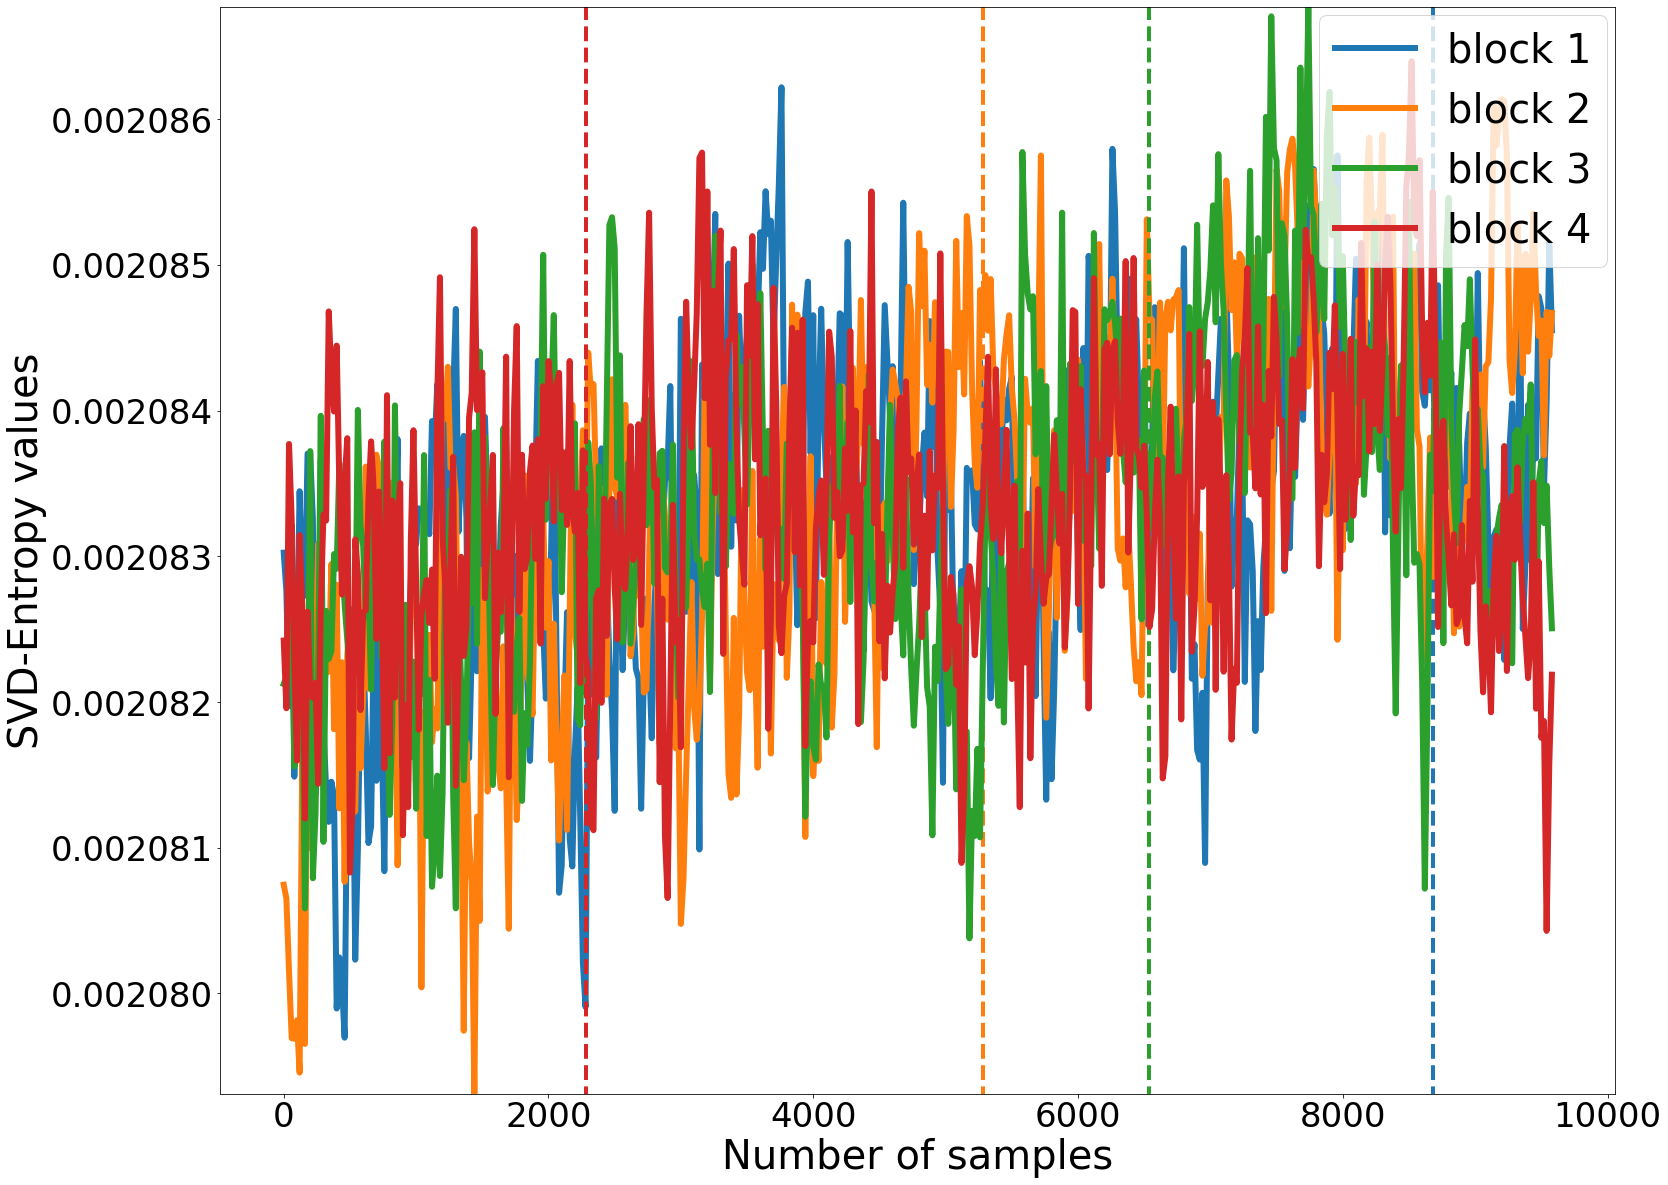

In [45]:
step_value = 20
label_freq = 50
max_value = 0
min_value = 100000

fig, ax = plt.subplots(figsize=(25, 20))
zones_names = [ "block " + str(i + 1) for i in zones_indices ]
#p_ylim = 0, 0.001

colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
ax.set_facecolor('#FFFFFF')
#fig.patch.set_facecolor('#F9F9F9')

ax.tick_params(labelsize=34)
ax.set_xticks(np.arange(0, 600, step=100))
#print([ 20 * i + 20 for i in list(range(500)) ])
ax.set_xticklabels([0, 2000, 4000, 6000, 8000, 10000])

ax.set_ylabel('SVD-Entropy values', fontsize=40)
ax.set_xlabel('Number of samples', fontsize=40)

for index, row in zones_entropies.items():
    
    if index < 4:
        row = np.array(row) 
        row = utils.normalize_arr(row[20:])
 
        plt.plot(row, label=zones_names[index], color=colors[index], lw=6)
        
        if np.max(row) > max_value:
            max_value = np.max(row)
        if np.min(row) < min_value:
            min_value = np.min(row)
            
        threshold_id = int(thresholds_scene[index] / 20)
        value = row[threshold_id]
        plt.plot([threshold_id, threshold_id], [value - 0.0002, value + 0.0002], linestyle='--', lw=4, color=colors[index])

# draw vertical line from (70,100) to (70, 250)

#x_labels = [id * step_value + start_index for id, val in enumerate(row[5:]) if id % label_freq == 0]

#x = [v for v in np.arange(0, len(row[5:])+1) if v % label_freq == 0]

plt.legend(loc=1, borderaxespad=0.2, fontsize=40)

#plt.xticks(x, x_labels, rotation=45)
plt.ylim(min_value, max_value)

plt.savefig("tmp_images/"+scene_name+"_svd_entropy_blocks.png" , transparent=True)
plt.plot()


### Model comparisons and k param selection

In [24]:
# SVD-Entropy
auc_roc = [0.8453289102036013, 0.8571528199630755, 0.8596871835061489, 0.8632081126706536, 0.8630899506801999, 0.8638, 0.8593764622664589, 0.8663927206714245]
label_title = "RNN with SVD-Entropy"
output_image_name = "tmp_images/k_param_curve_svd-entropy.png"
index_auc = 3

In [22]:
# 26 attributes
auc_roc = [0.7692, 0.7882, 0.7940, 0.7857, 0.7976, 0.7692, 0.7910, 0.7806]
label_title = "RNN with Constantin attributes"
output_image_name = "tmp_images/k_param_curve_26-attributes.png"
index_auc = 2

[]

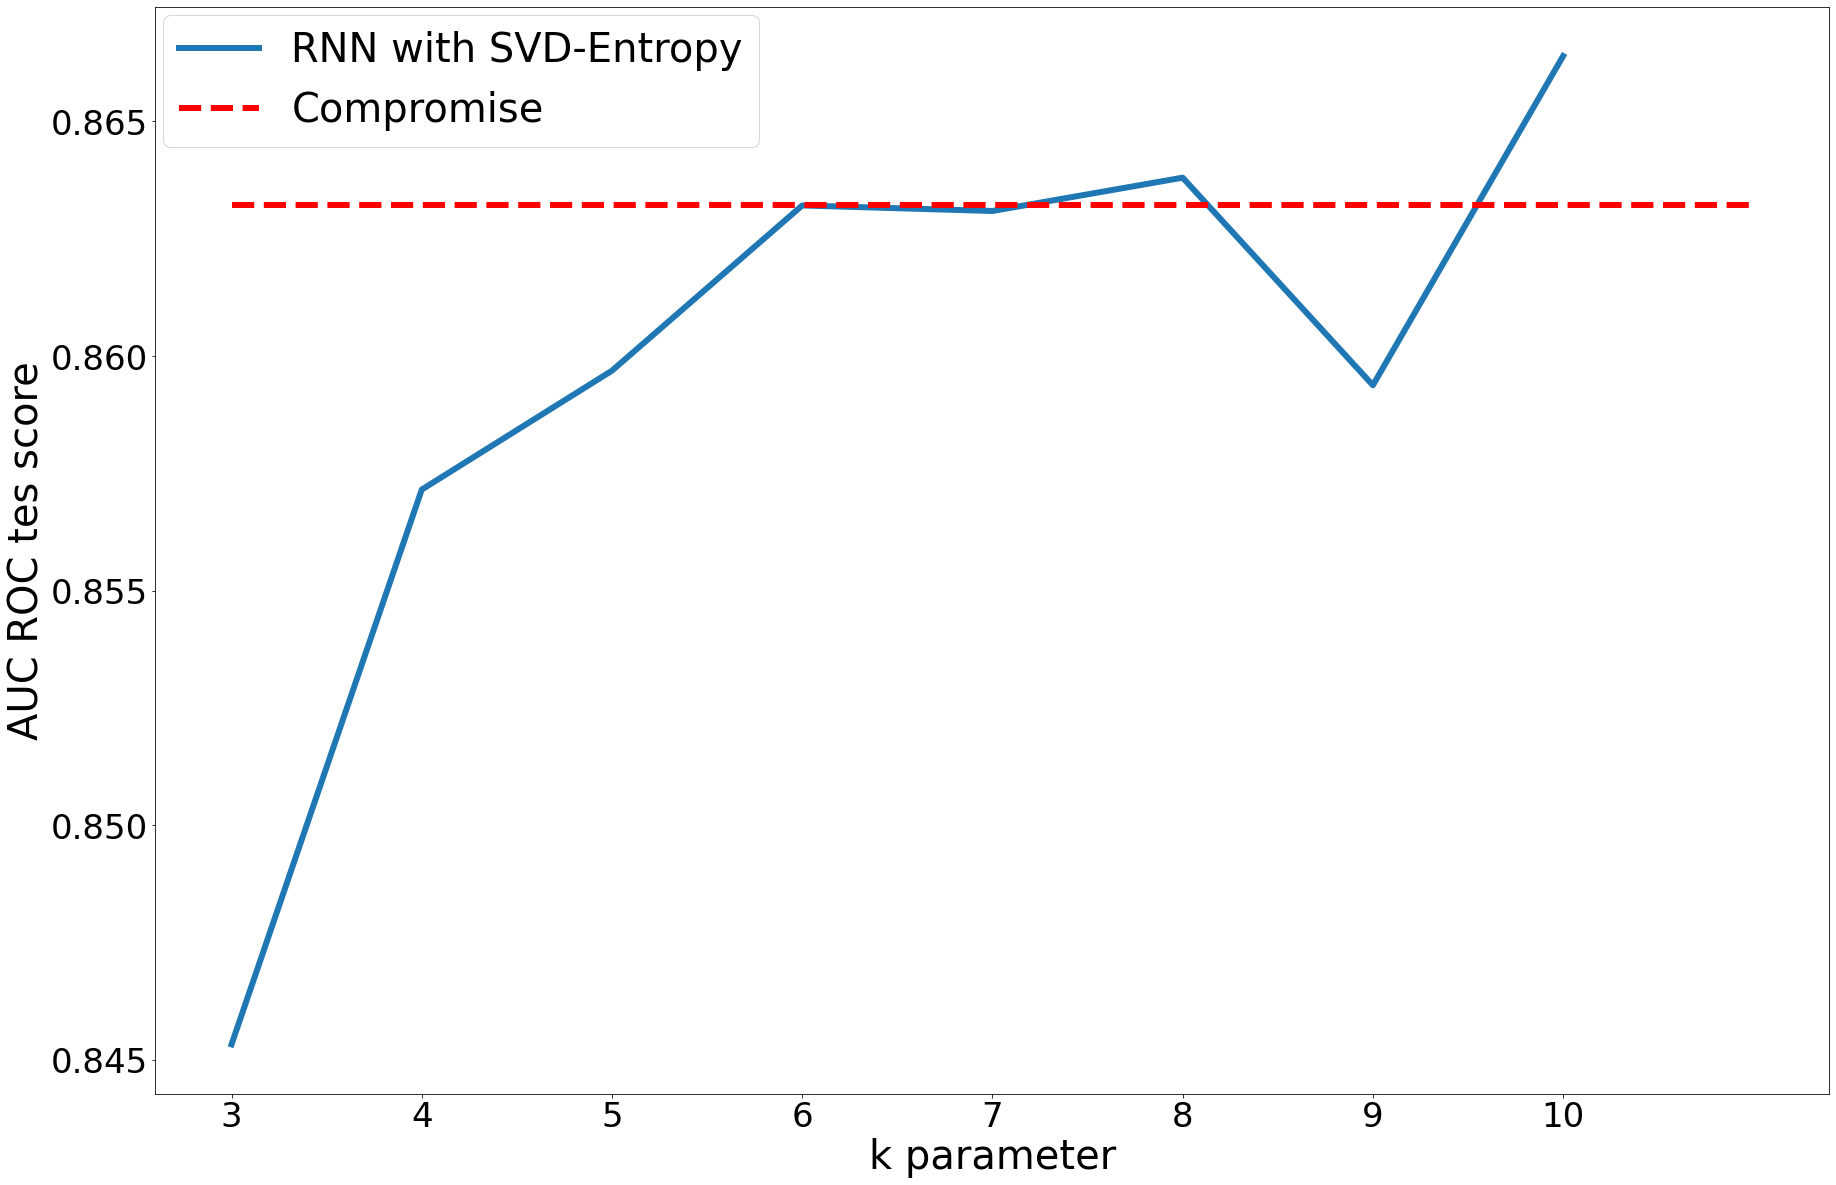

In [25]:
fig, ax = plt.subplots(figsize=(30, 20))

ax.set_facecolor('#FFFFFF')
#fig.patch.set_facecolor('#F9F9F9')

ax.tick_params(labelsize=34)
ax.set_xticks(range(len(auc_roc)))
#print([ 20 * i + 20 for i in list(range(500)) ])
ax.set_xticklabels(range(3, 11))

#means = auc_roc
#confidences = (1.9 * np.std(auc_roc)) / np.sqrt(len(auc_roc))

from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(3, 11, 300) 

spl = make_interp_spline(range(3,11), auc_roc, k=3)  # type: BSpline
power_smooth = spl(xnew)

        
ax.set_ylabel('AUC ROC tes score', fontsize=40)
ax.set_xlabel('k parameter', fontsize=40)

plt.plot(auc_roc, label=label_title, lw=6)
plt.plot([0, 8], [auc_roc[index_auc], auc_roc[index_auc]], label="Compromise", lw=6, color='red', linestyle="--")
#plt.plot(xnew, power_smooth, label=zones_names[index], lw=6)
#plt.fill_between(range(len(auc_roc)), means-confidences, means+confidences, alpha=.25)

plt.legend(loc=2, borderaxespad=0.2, fontsize=40)

#plt.xticks(x, x_labels, rotation=45)
#plt.ylim(min_value, max_value)

plt.savefig(output_image_name , transparent=True)
plt.plot()